<a href="https://colab.research.google.com/github/mprovenc/covid19_forecasting/blob/master/covid_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing the SIR and LSTM Models for Predicting Cases of COVID-19 in the US



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
confirmed_us = pd.read_csv("/content/drive/My Drive/time_series_covid19_confirmed_US.csv")
deaths_us = pd.read_csv("/content/drive/My Drive/time_series_covid19_deaths_US.csv")

In [0]:
# get rid of first few columns, we don't need them 
confirmed_us = confirmed_us.iloc[:,11:]
deaths_us = deaths_us.iloc[:,12:]


In [0]:
# cumulative confirmed and deaths obtained from summing up all columns
cum_confirmed_us = confirmed_us.sum(axis=0)
cum_deaths_us = deaths_us.sum(axis=0)

# using the cumulative values to get new deaths and confirmed cases per day
daily_confirmed_us = cum_confirmed_us.diff().fillna(0)
daily_deaths_us = cum_deaths_us.diff().fillna(0)

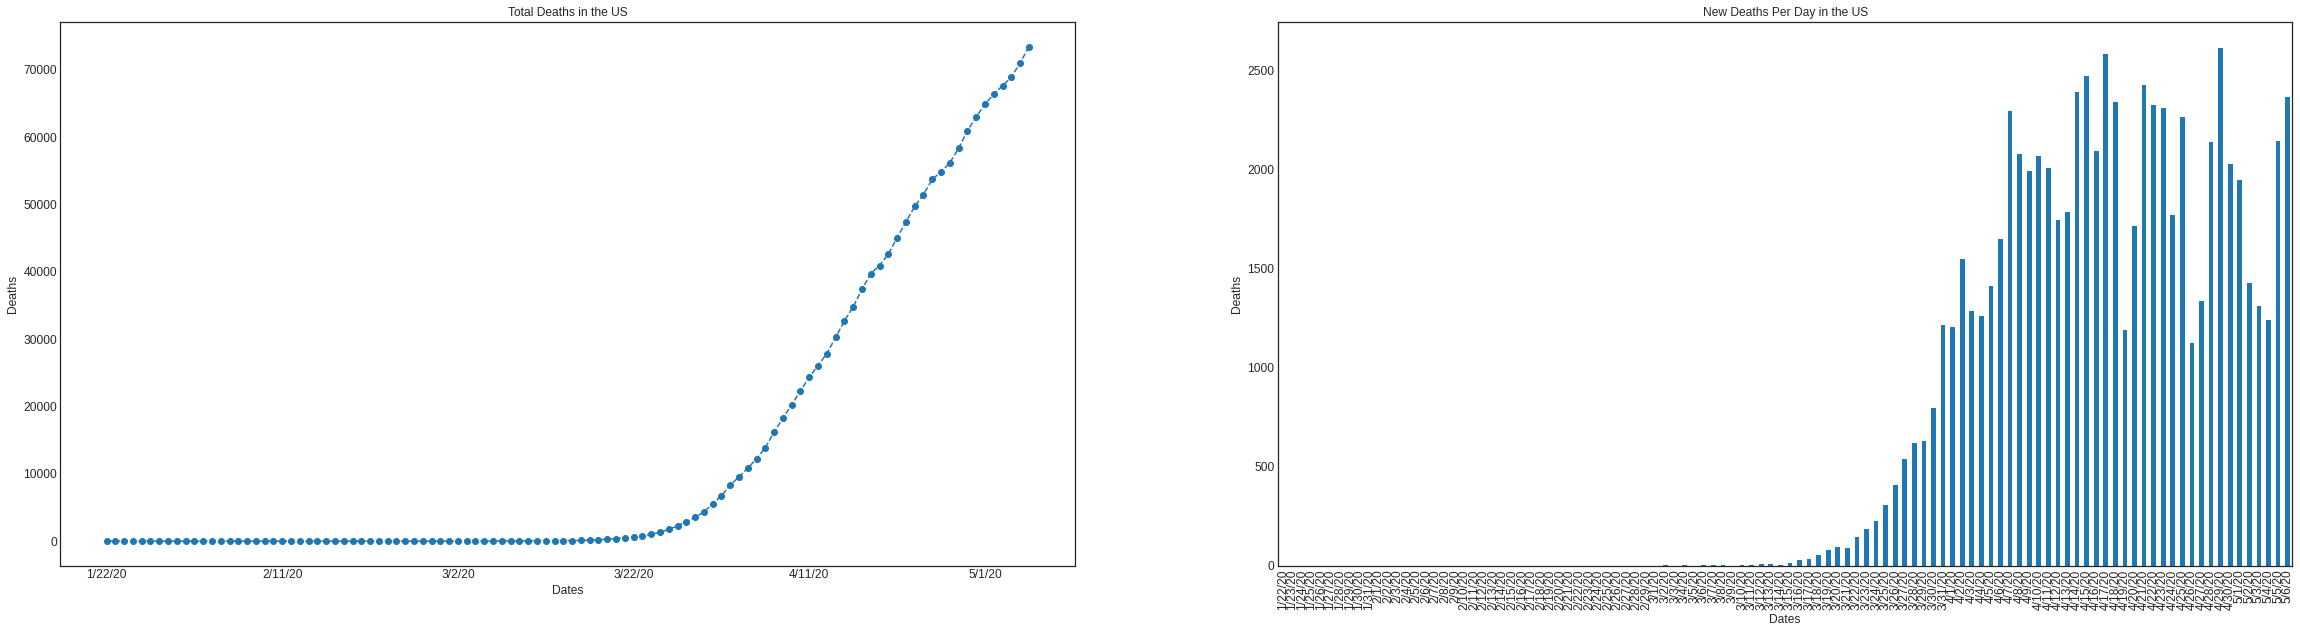

In [5]:
plt.style.use('seaborn-white')

# Generating plots from raw times series data for cumulative and non-cumulative deaths
fig, axs = plt.subplots(ncols = 2, figsize = (30,10))

cum_deaths_us.plot(kind='line', linestyle='--', marker='o', title ="Total Deaths in the US",figsize=(40,10), fontsize=12, ax=axs[0])
daily_deaths_us.plot(kind='bar', title ="New Deaths Per Day in the US",figsize=(40,10), fontsize=12, ax=axs[1])

axs[0].set_xlabel("Dates",fontsize=12)
axs[0].set_ylabel("Deaths",fontsize=12)
axs[1].set_xlabel("Dates",fontsize=12)
axs[1].set_ylabel("Deaths",fontsize=12)

plt.show()

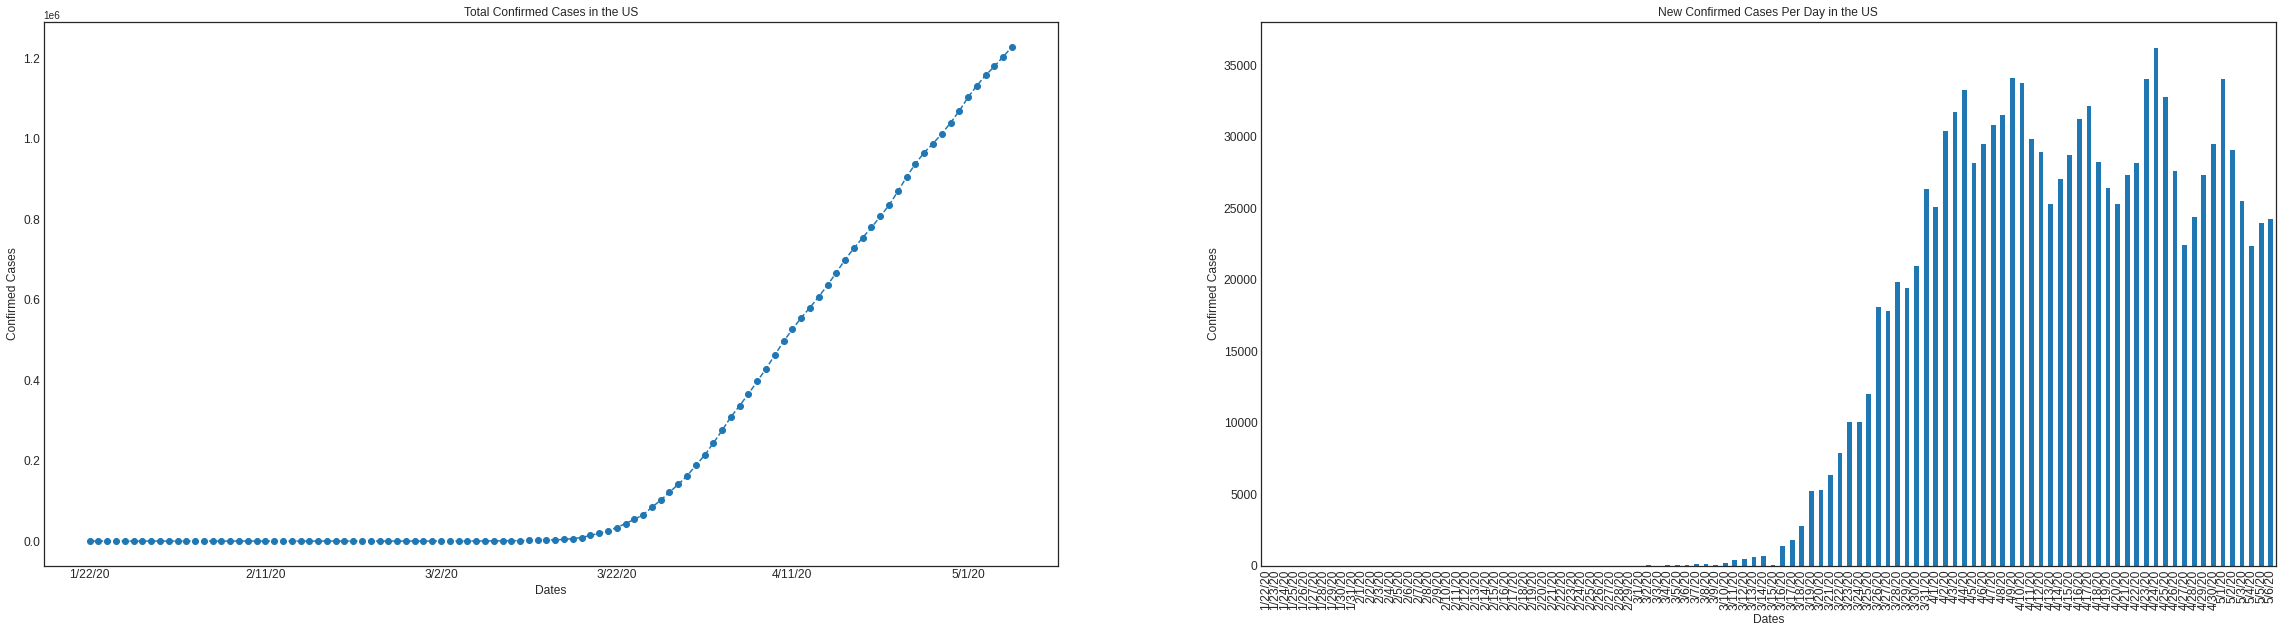

In [6]:
fig, axs = plt.subplots(ncols = 2)

# Generating plots from raw times series data for cumulative and non-cumulative confirmed cases

cum_confirmed_us.plot(kind='line', linestyle='--', marker='o', title ="Total Confirmed Cases in the US",figsize=(40,10), fontsize=12, ax=axs[0])
daily_confirmed_us.plot(kind='bar', title ="New Confirmed Cases Per Day in the US",figsize=(40,10), fontsize=12, ax=axs[1])

axs[0].set_xlabel("Dates",fontsize=12)
axs[0].set_ylabel("Confirmed Cases",fontsize=12)
axs[1].set_xlabel("Dates",fontsize=12)
axs[1].set_ylabel("Confirmed Cases",fontsize=12)

plt.show()

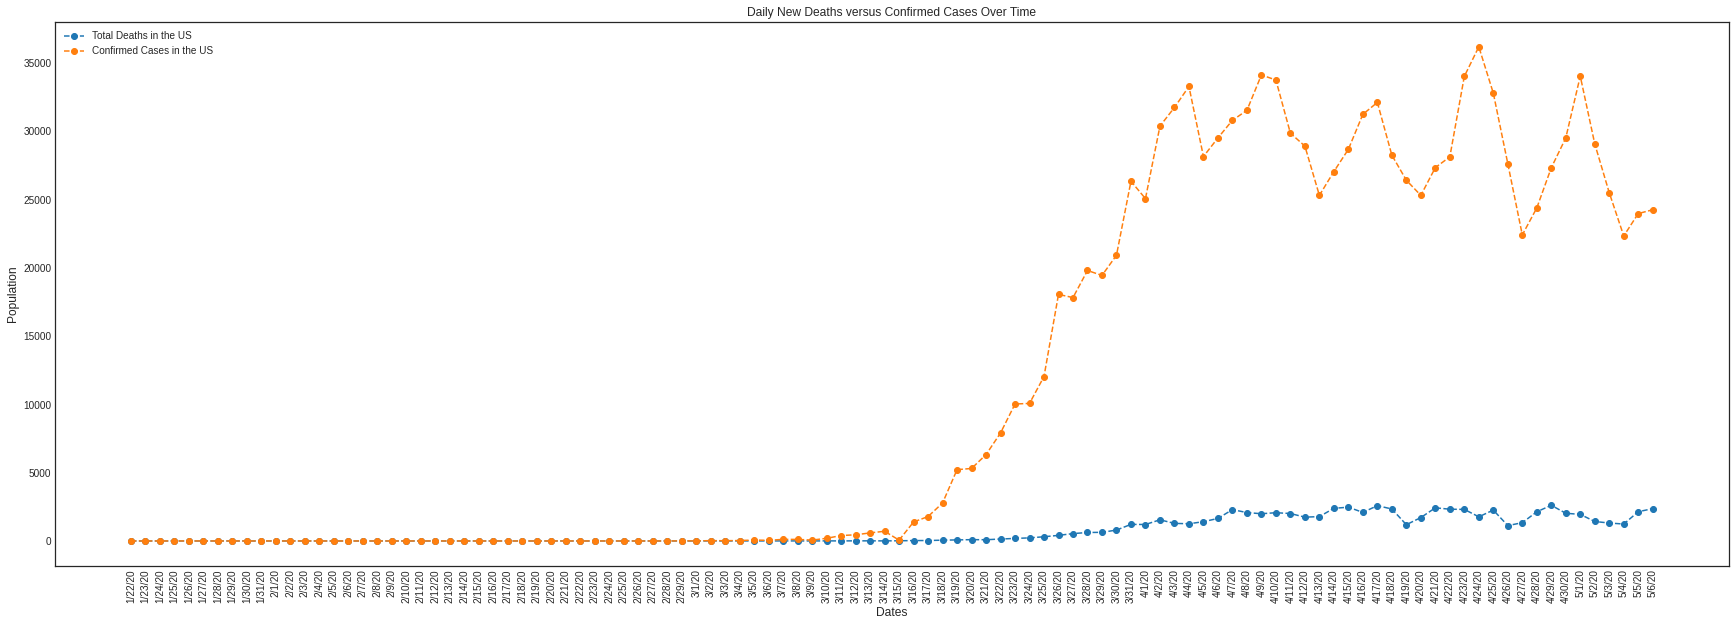

In [7]:
# Plotting daily deaths versus daily confirmed cases

fig=plt.figure(figsize=(30,10))
fig.show()
ax=fig.add_subplot(111)
plt.xticks(rotation=90)

ax.plot(daily_deaths_us, label ="Total Deaths in the US", linestyle='--', marker='o')
ax.plot(daily_confirmed_us, label ="Confirmed Cases in the US", linestyle='--', marker='o')

ax.set_xlabel("Dates",fontsize=12)
ax.set_ylabel("Population",fontsize=12)
ax.set_title("Daily New Deaths versus Confirmed Cases Over Time")

plt.legend(loc="upper left")
plt.show()

# The Unfitted SIR Model
I want to acknowledge the following resource for help with implementing the SIR model (both fitted and unfitted) in Python:

https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions

In [0]:
'''
These three differential equations define the SIR model
  dS_dt = -(beta*S*I)/N
  dI_dt = ((beta*S*I)/N) - gamma*I
  dR_dt = gamma*I

beta denotes the contagion rate (rate of S to I)
gamma denotes the recovery rate (rate of I to R)

'''

def sir_dS_dt(beta, S, I, N):
  return (-beta * S * I /N)

def sir_dI_dt(beta, S, I, N, gamma):
  return (beta * S * I / N - gamma * I)

def sir_dR_dt(gamma, I):
  return (gamma * I)
'''
Runge-Kutta 4th order approximation method of solving these differential equations
This function performs a single iteration of the Runge-Kutta formulas
'''
def sir_runge_kutta(S0, I0, R0, N, beta, gamma, h=0.2):
  
  # 1st order, increment based on slope at beginning of the interval
  S1= sir_dS_dt(beta, S0, I0, N) * h
  I1= sir_dI_dt(beta, S0, I0, N, gamma) * h
  R1= sir_dR_dt(gamma, I0) * h

  S2= sir_dS_dt(beta, S0 + S1*0.5, I0 + I1*0.5, N) * h
  I2= sir_dI_dt(beta, S0 + S1*0.5, I0 + I1*0.5, N, gamma) * h
  R2= sir_dR_dt(gamma, I0 + I1*0.5) * h

  S3= sir_dS_dt(beta, S0 + S2*0.5, I0 + I2*0.5, N) * h
  I3= sir_dI_dt(beta, S0 + S2*0.5, I0 + I2*0.5, N, gamma) * h
  R3= sir_dR_dt(gamma, I0 + I2*0.5) * h

  S4= sir_dS_dt(beta, S0 + S3, I0 + I3, N) * h
  I4= sir_dI_dt(beta, S0 + S3, I0 + I3, N, gamma) * h
  R4= sir_dR_dt(gamma, I0 + I3) * h

  S_next= S0 + S1/6 + S2/3 + S3/3 + S4/6
  I_next= I0 + I1/6 + I2/3 + I3/3 + I4/6
  R_next= R0 + R1/6 + R2/3 + R3/3 + R4/6

  return S_next, I_next, R_next

# helper function to generate many values from the Runge-Kutta approximations
def fit_SIR(S0, I0, R0, N, beta, gamma):

  S,I,R = [],[],[]

  S.append(S0)
  I.append(I0)
  R.append(R0)

  for i in range(10000):
    S_next,I_next,R_next = sir_runge_kutta(S[i],I[i],R[i],beta,gamma, 0.1)

    S.append(S_next)
    I.append(I_next)
    R.append(R_next)
  
  return S,I,R

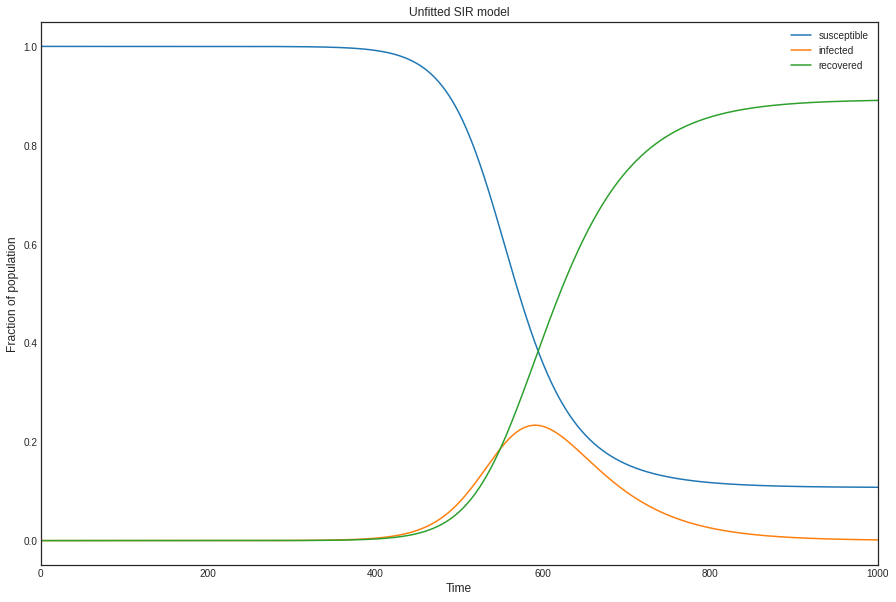

In [9]:
# Assuming N is the population of the US and there is one infected person at the start of the epidemic
N= 329610666
S0= N-1
I0= 1
R0= 0
beta= 0.8
gamma= 0.2

S,I,R = fit_SIR(float(N-10)/N, float(10/N), R0, N, beta, gamma)

# Plot the unfitted model
f = plt.figure(figsize=(15,10)) 
plt.plot(S, label='susceptible');
plt.plot(I, label='infected');
plt.plot(R, label='recovered');
plt.title("Unfitted SIR model")
plt.xlabel("Time", fontsize=12);
plt.ylabel("Fraction of population", fontsize=12);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars


Optimized parameters: beta = 9.045340, gamma = 8.906081


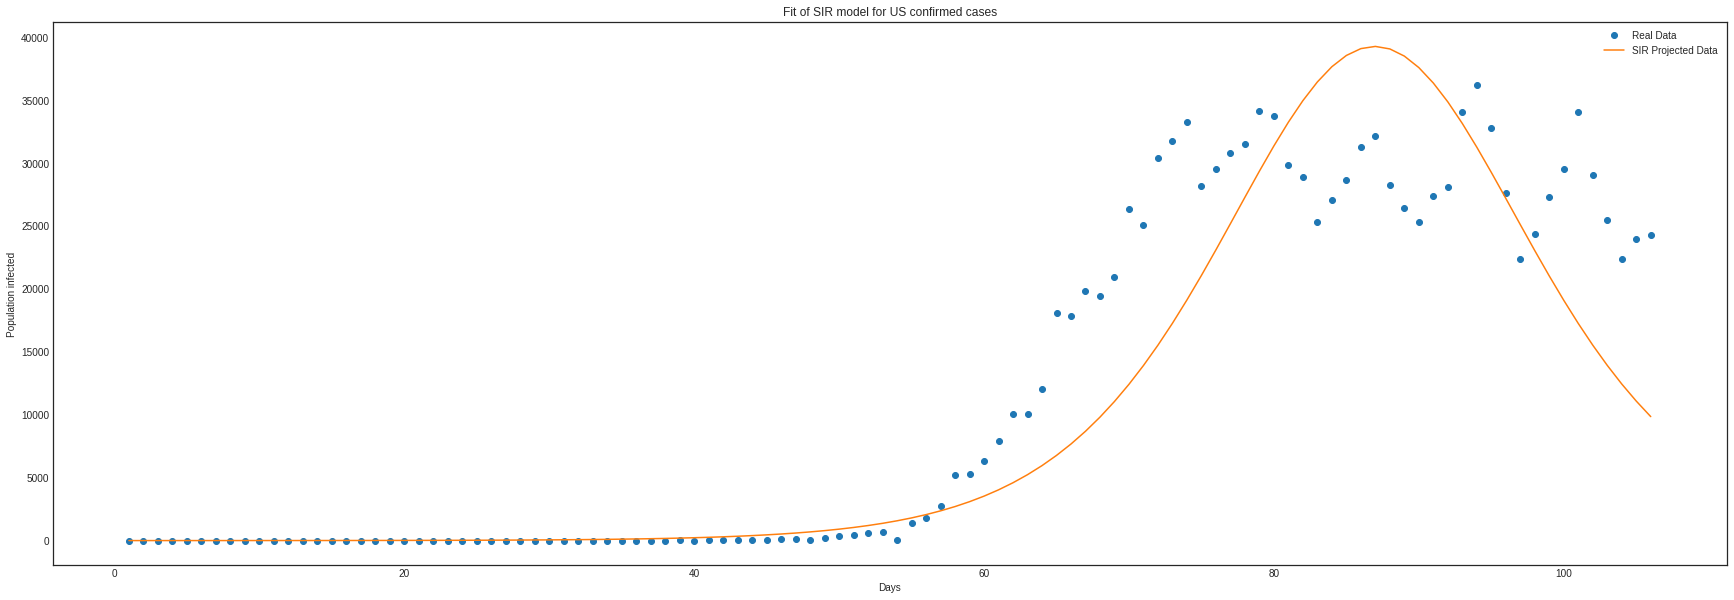

In [10]:
'''
  Code in this cell is very similar to https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions
  Same initial assumptions about N and I0 as for the unfitted model.
'''

ydata= np.array(daily_confirmed_us, dtype=float)
xdata= np.array(list(range(1,len(ydata)+1)), dtype=float)

us_population= float(329610666)

N= us_population
I0= 1
S0= N - I0
R0= 0.0

init = (S0, I0, R0)

# a single function for the different equations
def SIR_model(y, x, beta, gamma):
  dS= -beta * y[0] * y[1] /N
  dR= gamma * y[1]
  dI= -(dS + dR)  

  return dS, dI, dR

def solve_ode_return_I(x, beta, gamma):
  sol = odeint(SIR_model, init, x, args=(beta,gamma))
  return sol[:,1]

# optimize beta and gamma by fitting daily_confirmed_us to SIR model
popt, pcov = curve_fit(solve_ode_return_I, xdata, ydata)
print("Optimized parameters: beta = %3f, gamma = %3f" % (popt[0], popt[1]))
fitted= solve_ode_return_I(xdata,popt[0],popt[1])

# plot results
plt.figure(figsize=(30,10)) 
plt.plot(xdata, ydata, 'o', label="Real Data")
plt.plot(xdata, fitted, label="SIR Projected Data")
plt.title("Fit of SIR model for US confirmed cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.legend()
plt.show()


In [11]:
# get mean squared error of the above plot
from sklearn.metrics import mean_squared_error
mean_squared_error(ydata, fitted)

38617200.87201244

In [12]:
# get the viral reproduction rate R_e
popt[0]/popt[1]

1.0156364173503705

In [0]:
# Function to predict future values of S, I, and R for a given number of days
def forecast_sir(num_days, beta, gamma, S, I, R, N):
  predicted_S = np.zeros(num_days+1)
  predicted_S[0] = S

  predicted_I = np.zeros(num_days+1)
  predicted_I[0] = I

  predicted_R = np.zeros(num_days+1)
  predicted_R[0] = R

  reprod_rates = np.zeros(num_days+1)
  reprod_rates[0] = beta/gamma

  new_cases_per_day = np.zeros(num_days)
  
  days = np.array(range(num_days))
  
  #loops through old values to generate new values
  for i in range(num_days):
    snew = predicted_S[i] - ((predicted_S[i]/N)* (beta*predicted_I[i]))
    inew = predicted_I[i] + ((predicted_S[i]/N)* (beta*predicted_I[i])) - (predicted_I[i]*gamma)
    rnew = predicted_R[i] + (predicted_I[i] * gamma)

    predicted_S[i+1] = snew
    predicted_I[i+1] = inew
    predicted_R[i+1] = rnew
    reprod_rates[i+1] = reprod_rates[0] * (predicted_S[i]/N)
    new_cases_per_day[i] = ((predicted_S[i]/N)* (beta*predicted_I[i]))
  
  #plot the results
  fig, axs = plt.subplots(ncols = 2, figsize = (30,10))

  axs[0].plot(days, new_cases_per_day, 'o')
  axs[1].plot(days, reprod_rates[1:])

  axs[0].set_title("Predicted Number of New Cases per Day")
  axs[0].set_xlabel("Days",fontsize=12)
  axs[0].set_ylabel("Number of New Cases",fontsize=12)
  axs[1].set_title("Predicted Viral Reproduction Rate")
  axs[1].set_xlabel("Days",fontsize=12)
  axs[1].set_ylabel("Viral Reproduction Rate",fontsize=12)
  

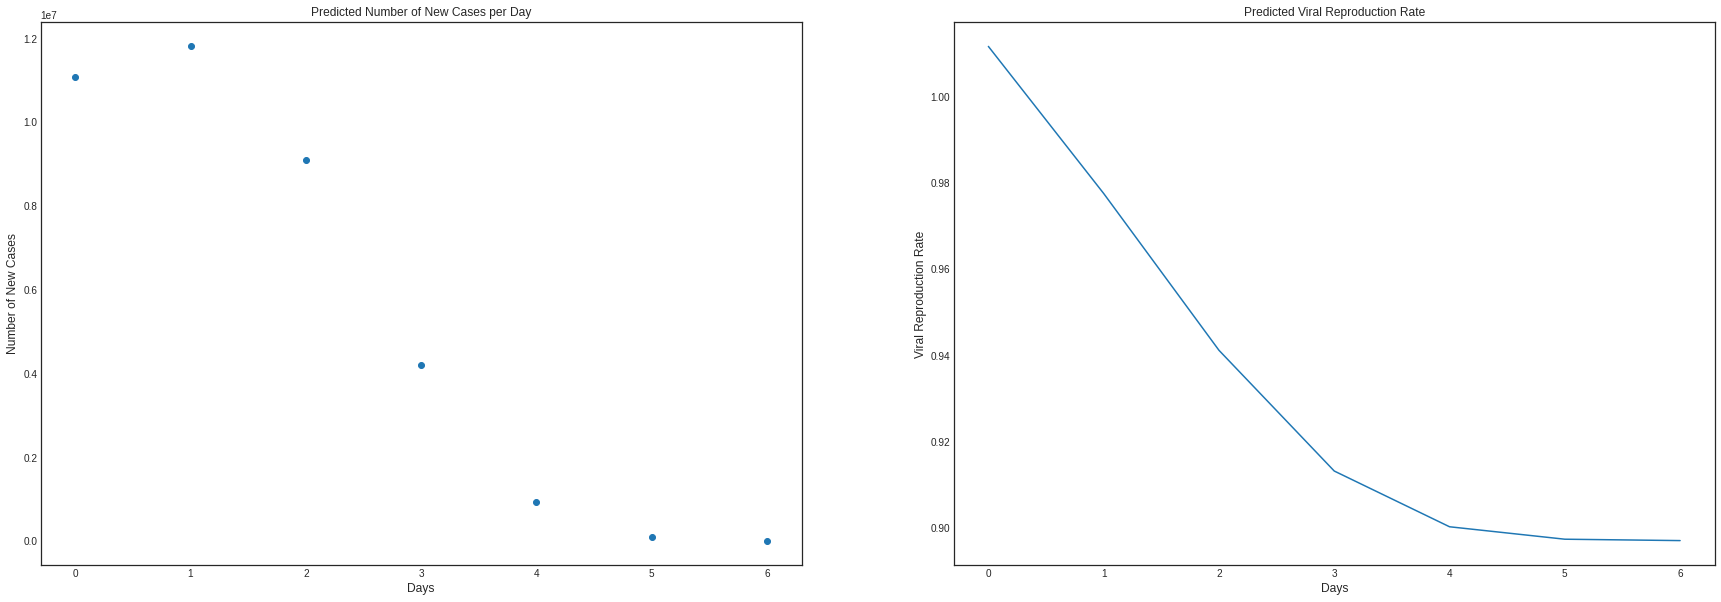

In [14]:
'''
  The number 189910 is the number of people who recovered from COVID-19 as of 5/6/2020
  Reference John Hopkins Time Series data:
  https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
'''
# forecast 7 days ahead
forecast_sir(7, popt[0], popt[1], N - cum_deaths_us[-1] - cum_confirmed_us[-1], cum_confirmed_us[-1], 189910 + cum_deaths_us[-1], N)

# Using a Recurrent Neural Network for Forecasting

The following cells outline a different approach to time series forecasting. In this approach, a single step Long Short Term Model (LSTM) recurrent neural network is trained on our data. This LSTM will be implemented in PyTorch, using the torch.nn.LSTM object. This object does the work of building the LSTM layer. Similar to the Skin Lesion Classification Project, a new class is created building off of the parent nn.Module. This class will contain information specific to this Covid LSTM model.

I want to acknowledge a couple of important resources that helped me to put together this implementation: <br/>
[Jessica Yung's blog posting on LSTM forecasting in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)<br/>
[Venilin Valkov's blog posting on using LSTM for Coronavirus cases](https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/)


In [0]:
'''
  Code in this cell taken from https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/
'''
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [0]:
# data set wil be split with a ~70/30 train/test ratio. Since we have 106 days of data, we will take the first 74 examples for training and the remaining 32 examples for testing.

test_data_size = 32

train_data = daily_confirmed_us[:-test_data_size]
test_data = daily_confirmed_us[-test_data_size:]


## Preprocessing

Before training the model, I took a couple of steps:
1. Rescaled all data between 0 and 1 for quicker training
2. Created a simple method to turn the time series data into data appropriate for supervised learning. This has the added benefit of a flexible number of x values (can do single-step forecasting or take chunks of size n).

In [0]:
'''
  Code in this cell taken from https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/
'''
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [0]:
# This function turns the time series data into supervised learning format (n exemplars with multiple x values and a single y value as output). The size of x is variable.
def ts_to_sl(data, x_size):
  X = []
  y = []

  for i in range(0,len(data)):
    x_j = []
    y_j = []
    if(i+x_size >= len(data)):
      break
    else:
      x_j = data[i:(i+x_size)]
      y_j = data[i+x_size]
    X.append(x_j)
    y.append(y_j)
  return np.array(X), np.array(y)

In [0]:
# Format train and test data for supervised learning
x_size = 5
X_train, y_train = ts_to_sl(train_data, x_size)
X_test, y_test = ts_to_sl(test_data, x_size)

# create tensors for train and test data
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [20]:
# sample of X_train tensors
X_train[:2]

tensor([[[0.0000e+00],
         [0.0000e+00],
         [3.0045e-05],
         [0.0000e+00],
         [9.0136e-05]],

        [[0.0000e+00],
         [3.0045e-05],
         [0.0000e+00],
         [9.0136e-05],
         [0.0000e+00]]])

## Defining the Model

In [0]:
'''
  Much code in this cell taken from https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/
  Some code taken from https://www.jessicayung.com/lstms-for-time-series-in-pytorch/
  Some minor changes
'''

class Covid_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, dropout = 0.5, num_layers=2):
        super(Covid_LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define two layers: the LSTM layer and the output layer
        self.lstm = nn.LSTM(hidden_size = self.hidden_dim, input_size = self.input_dim, num_layers = self.num_layers, dropout = dropout)
        self.hiddenToOut = nn.Linear(in_features = self.hidden_dim, out_features = 1)

    # Forward pass through LSTM layer (all x_j values go through the layer)
    # Forward pass through output later to get a single prediction
    def forward(self, input):
      lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1), self.hidden)
      y_pred = self.hiddenToOut(lstm_out.view(self.batch_size, len(input), self.hidden_dim)[-1])
      return y_pred

    # reinitializes the hidden state back to zeros
    def init_hidden_state(self):
      self.hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim), torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

In [0]:
'''
  Much code in this cell taken from https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/
  Some changes to input parameters and slight change of implementation to train and test on input parameters instead of X_train and X_test
'''

# a helper function for training the model
def fit_LSTM(model, train_data, train_labels, num_epochs, test_data=None, test_labels=None):
  # define the loss function and optimizer
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

  #num_epochs = 300
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  # going through one epoch at a time
  for t in range(num_epochs):
    # clears the model's state after each epoch
    model.init_hidden_state()
    model.zero_grad()

    # a single forward pass
    y_pred = model(train_data)

    # measure the loss
    loss = loss_fn(y_pred.float(), train_labels)

    # check against the test data and measure accuracy
    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(test_data)
        test_loss = loss_fn(y_test_pred.float(), test_labels)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    # add losses to a list for plotting later
    train_hist[t] = loss.item()

    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # parameter update
    optimizer.step()

  return model.eval(), train_hist, test_hist

In [23]:
model = Covid_LSTM(
  input_dim=1,
  hidden_dim=512,
  batch_size=5
)

# train model on 300 epochs
model, train_hist, test_hist = fit_LSTM(
  model,
  X_train,
  y_train,
  300,
  X_test,
  y_test
)

Epoch 0 train loss: 5.793379783630371 test loss: 19.244951248168945
Epoch 10 train loss: 5.593335151672363 test loss: 18.64078712463379
Epoch 20 train loss: 5.377711772918701 test loss: 17.936800003051758
Epoch 30 train loss: 5.229859352111816 test loss: 17.367977142333984
Epoch 40 train loss: 5.084704875946045 test loss: 16.738082885742188
Epoch 50 train loss: 4.979553699493408 test loss: 16.157634735107422
Epoch 60 train loss: 4.872443199157715 test loss: 15.541831016540527
Epoch 70 train loss: 4.814251899719238 test loss: 15.150430679321289
Epoch 80 train loss: 4.763434886932373 test loss: 14.65355110168457
Epoch 90 train loss: 4.708047866821289 test loss: 14.165460586547852
Epoch 100 train loss: 4.67698335647583 test loss: 13.867706298828125
Epoch 110 train loss: 4.635458946228027 test loss: 13.529568672180176
Epoch 120 train loss: 4.600096225738525 test loss: 13.300106048583984
Epoch 130 train loss: 4.5978288650512695 test loss: 13.044195175170898
Epoch 140 train loss: 4.552077293

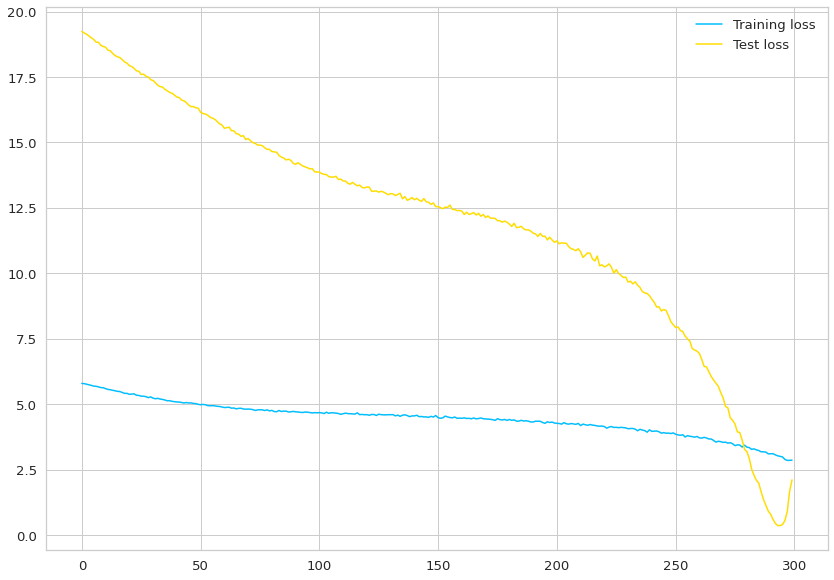

In [24]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

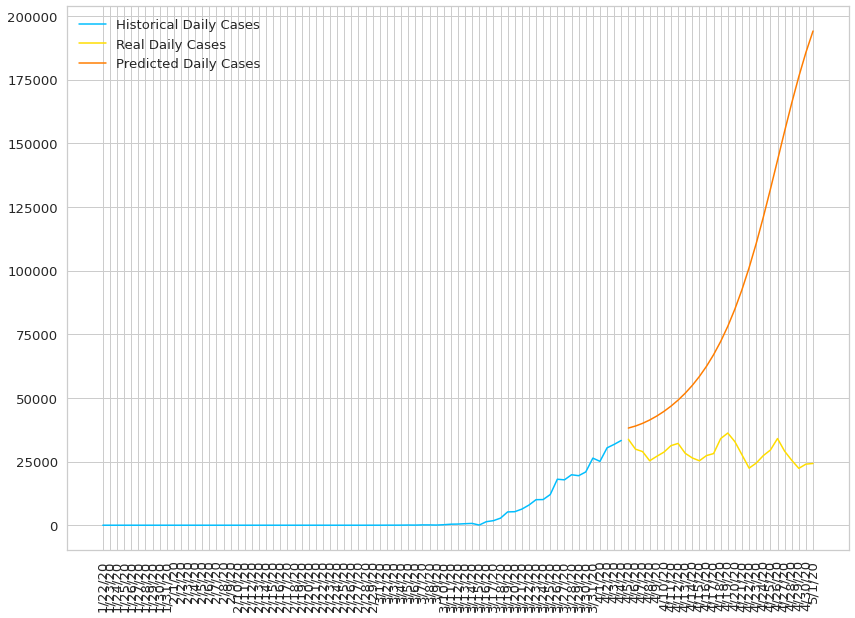

In [25]:
'''
  Code in this cell taken from https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/
'''
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, x_size, 1).float()

true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

plt.plot(
  daily_confirmed_us.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)
plt.plot(
  daily_confirmed_us.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)
plt.plot(
  daily_confirmed_us.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)
plt.legend()
plt.xticks(rotation=90)
plt.show()

## Second LSTM Model without the first 20 exemplars

In [0]:
# trying to cut out first 20 or so training examples where there was very little data to see if we get a better fit
# data set wil be split with a ~70/30 train/test ratio. Since we have 86 days of data now, we will take the first 66 examples for training and the remaining 20 examples for testing.

test_data_size = 20

train_data = daily_confirmed_us[20:-test_data_size]
test_data = daily_confirmed_us[-test_data_size:]

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [0]:
# Format train and test data for supervised learning
x_size = 5
X_train, y_train = ts_to_sl(train_data, x_size)
X_test, y_test = ts_to_sl(test_data, x_size)

# create tensors for train and test data
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [29]:
model = Covid_LSTM(
  input_dim=1,
  hidden_dim=512,
  batch_size=5
)

model, train_hist, test_hist = fit_LSTM(
  model,
  X_train,
  y_train,
  320,
  X_test,
  y_test
)

Epoch 0 train loss: 16.087839126586914 test loss: 11.024127006530762
Epoch 10 train loss: 15.51012897491455 test loss: 10.674056053161621
Epoch 20 train loss: 14.867141723632812 test loss: 10.329288482666016
Epoch 30 train loss: 14.460624694824219 test loss: 9.97861099243164
Epoch 40 train loss: 13.882223129272461 test loss: 9.635154724121094
Epoch 50 train loss: 13.387612342834473 test loss: 9.3142728805542
Epoch 60 train loss: 12.841439247131348 test loss: 8.955471992492676
Epoch 70 train loss: 12.283628463745117 test loss: 8.56547737121582
Epoch 80 train loss: 11.763786315917969 test loss: 8.077616691589355
Epoch 90 train loss: 11.174373626708984 test loss: 7.674569129943848
Epoch 100 train loss: 10.559977531433105 test loss: 7.118132591247559
Epoch 110 train loss: 10.02911376953125 test loss: 6.693321228027344
Epoch 120 train loss: 9.467512130737305 test loss: 6.065165042877197
Epoch 130 train loss: 9.048880577087402 test loss: 5.393346309661865
Epoch 140 train loss: 8.694430351257

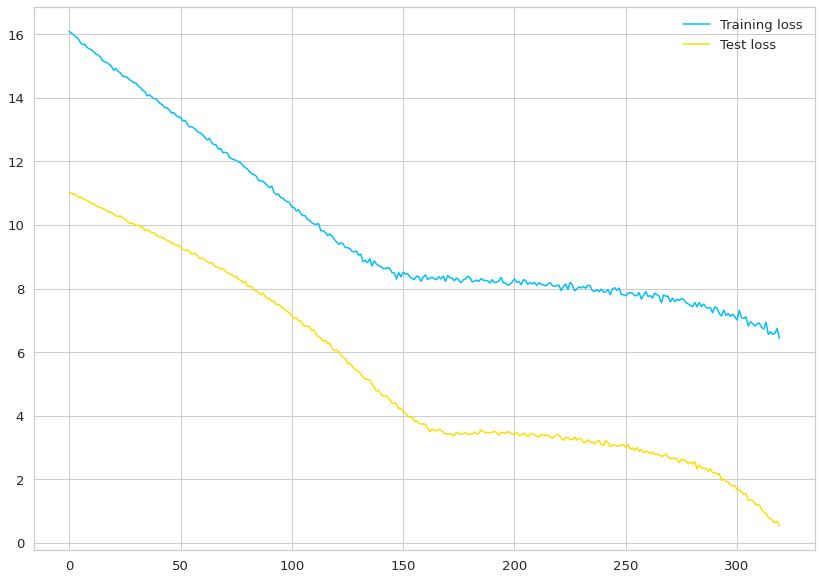

In [30]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

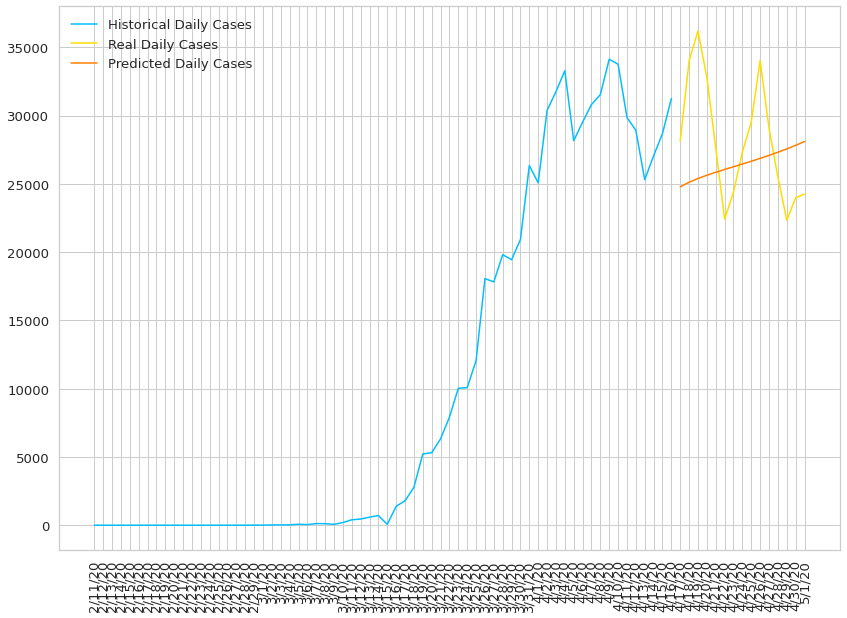

In [31]:
'''
  Code in this cell taken from https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/
'''

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, x_size, 1).float()

true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

plt.plot(
  daily_confirmed_us.index[20:len(train_data)+20],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)
plt.plot(
  daily_confirmed_us.index[len(train_data)+20:len(train_data) + len(true_cases) +20],
  true_cases,
  label='Real Daily Cases'
)
plt.plot(
  daily_confirmed_us.index[len(train_data)+20:len(train_data) + len(true_cases)+20],
  predicted_cases,
  label='Predicted Daily Cases'
)
plt.legend()
plt.xticks(rotation=90)
plt.show()

## Final LSTM Model training on all data

In [32]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_confirmed_us[20:], axis=1))
all_data = scaler.transform(np.expand_dims(daily_confirmed_us[20:], axis=1))
all_data.shape

(86, 1)

In [33]:
X_all, y_all = ts_to_sl(all_data, x_size)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = Covid_LSTM(
  input_dim=1,
  hidden_dim=512,
  batch_size=5
)

model, train_hist, _ = fit_LSTM(
  model,
  X_all,
  y_all,
  300
)

Epoch 0 train loss: 26.384185791015625
Epoch 10 train loss: 25.283985137939453
Epoch 20 train loss: 24.29143714904785
Epoch 30 train loss: 23.378263473510742
Epoch 40 train loss: 22.3825626373291
Epoch 50 train loss: 21.43766975402832
Epoch 60 train loss: 20.371875762939453
Epoch 70 train loss: 19.336135864257812
Epoch 80 train loss: 18.331815719604492
Epoch 90 train loss: 17.14533233642578
Epoch 100 train loss: 16.023178100585938
Epoch 110 train loss: 14.782140731811523
Epoch 120 train loss: 13.562111854553223
Epoch 130 train loss: 12.547490119934082
Epoch 140 train loss: 11.912191390991211
Epoch 150 train loss: 11.528685569763184
Epoch 160 train loss: 11.443309783935547
Epoch 170 train loss: 11.566108703613281
Epoch 180 train loss: 11.545175552368164
Epoch 190 train loss: 11.369041442871094
Epoch 200 train loss: 11.533525466918945
Epoch 210 train loss: 11.517927169799805
Epoch 220 train loss: 11.357128143310547
Epoch 230 train loss: 11.469279289245605
Epoch 240 train loss: 11.4737892

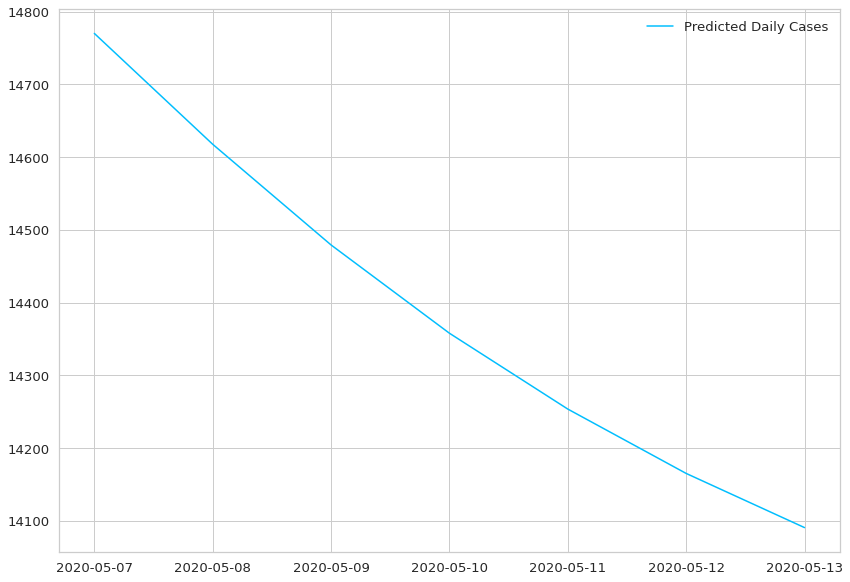

In [34]:
'''
  Code in this cell taken from https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/
'''

# Forecast 7 days ahead
DAYS_TO_PREDICT = 7

# Uses predicted values to predict new ones
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, 5, 1).float()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

predicted_index = pd.date_range(
  start=daily_confirmed_us.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();


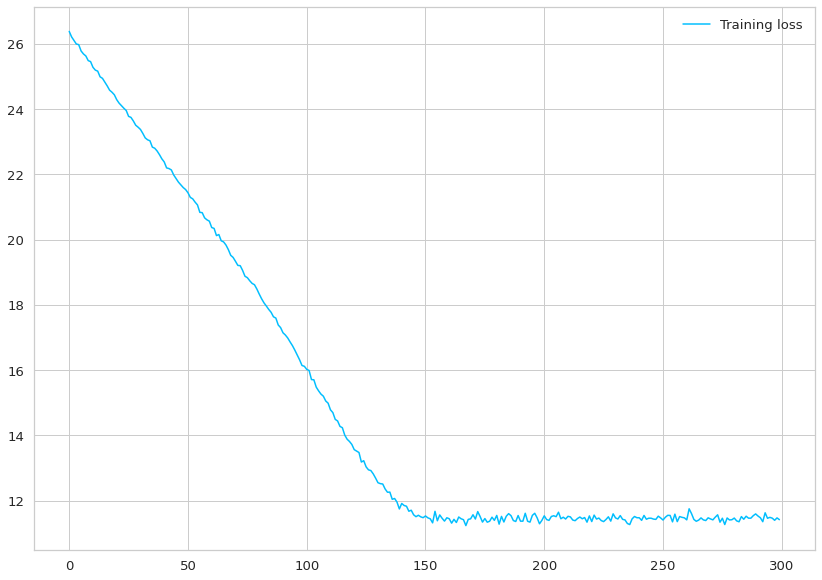

In [35]:
# Generate plot to measure training loss on final model
plt.plot(train_hist, label="Training loss")
plt.legend();